**Load Library**

In [2]:
import os
import spacy
import pandas as pd
import numpy as np
import geopandas as gpd
import re
import math
import string
import unicodedata
import gensim
import matplotlib.pyplot as plt
import matplotlib as mpl
import nltk
import seaborn as sns
import contextily as ctx
import urllib.request
import ast  # 用于安全地将字符串转换为列表
import umap
import matplotlib.patheffects as PathEffects

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from scipy.spatial.distance import cdist

from shapely.geometry import Point

from sklearn.preprocessing import OneHotEncoder  # We don't use this but I point out where you *could*
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.svm import SVC



from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk import ngrams, FreqDist

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.matutils import Sparse2Corpus
from gensim.matutils import corpus2dense
from gensim.models import tfidfmodel
from gensim.models import Word2Vec
from gensim.models import TfidfModel
from gensim.models import KeyedVectors
from gensim.models.ldamodel import LdaModel

from bs4 import BeautifulSoup
from wordcloud import WordCloud, STOPWORDS

from joblib import dump
from joblib import load



**用于Word2Vec模型的数据preprocessing**

In [3]:

Airbnb_Listing = pd.read_csv(os.path.join("..","Data","Airbnb_Listing_norm.csv"))

texts_word2vec = Airbnb_Listing['amenities_norm']

# 从norm并且split后的数据读取csv
amenities_norm_split = pd.read_csv(os.path.join("..","Data","amenities_norm_split.csv"),low_memory=False)

# 将 'amenities' 列中的字符串转换为列表
# 使用 ast.literal_eval 安全地评估字符串表达的列表
amenities_ast_literal = amenities_norm_split
amenities_ast_literal.drop('Unnamed: 0',axis=1)


list_of_lists = amenities_ast_literal.apply(lambda row: [item for item in row if item is not None], axis=1).tolist()

print(len(list_of_lists))


87946


In [3]:

# 准备用于 Word2Vec 的数据
# list_of_lists
"""
# 指定训练参数
dims = 500
window = 40

# 训练 Word2Vec 模型
model = Word2Vec(sentences=list_of_lists, vector_size=dims, window=window, min_count=2, workers=4)

# 保存word2vec模型
model.save(os.path.join("..","Model",f"word2vec-d{dims}-w{window}.model"))
"""


In [15]:
"""# 随机森林方法 Random Forest

#使用任何类型的分类器来预测是否income超过平均值
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(doc_vectors, Airbnb_Listing['profitable'], test_size=0.2, random_state=42)

# 训练分类器
classifier = RandomForestClassifier(n_estimators=300, random_state=42)
classifier.fit(X_train, y_train)

# 预测测试集
y_pred = classifier.predict(X_test)

# 评估模型
print("Accuracy:", accuracy_score(y_test, y_pred))
"""

'# 随机森林方法 Random Forest\n\n#使用任何类型的分类器来预测是否income超过平均值\n# 划分训练集和测试集\nX_train, X_test, y_train, y_test = train_test_split(doc_vectors, Airbnb_Listing[\'profitable\'], test_size=0.2, random_state=42)\n\n# 训练分类器\nclassifier = RandomForestClassifier(n_estimators=300, random_state=42)\nclassifier.fit(X_train, y_train)\n\n# 预测测试集\ny_pred = classifier.predict(X_test)\n\n# 评估模型\nprint("Accuracy:", accuracy_score(y_test, y_pred))\n'

In [16]:
"""
#SVM方法
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(doc_vectors, Airbnb_Listing['profitable'], test_size=0.2, random_state=42)

# 创建 SVM 分类器实例
svm_classifier = SVC(random_state=42)

# 训练分类器
svm_classifier.fit(X_train, y_train)

# 预测测试集
y_pred = svm_classifier.predict(X_test)

# 评估模型
print("Accuracy:", accuracy_score(y_test, y_pred))

"""

'\n#SVM方法\n# 划分训练集和测试集\nX_train, X_test, y_train, y_test = train_test_split(doc_vectors, Airbnb_Listing[\'profitable\'], test_size=0.2, random_state=42)\n\n# 创建 SVM 分类器实例\nsvm_classifier = SVC(random_state=42)\n\n# 训练分类器\nsvm_classifier.fit(X_train, y_train)\n\n# 预测测试集\ny_pred = svm_classifier.predict(X_test)\n\n# 评估模型\nprint("Accuracy:", accuracy_score(y_test, y_pred))\n\n'

保存SVM模型与保存后的Airbnb_Listing_norm_income

In [17]:
#dump(classifier, 'randforest_classfier_model.joblib')
#dump(svm_classifier, 'svm_classfier_model.joblib')

读取导入word2vec模型


In [4]:
# import Word2Vec Model from index
word2vec_model = Word2Vec.load(os.path.join("..","Model","word2vec-d500-w40.model"))

将训练后model应用于'amenities'列

In [5]:

"""# 预处理函数
def preprocess(text):
    # 这里添加文本清洗逻辑（例如：转换为小写，去除标点等）
    return text.lower()"""

# 向量化函数
def vectorize(text, model):
    # 将文本分解为单词，并过滤掉模型词汇表中不存在的单词
    words = [word for word in text if word in model.wv.key_to_index]
    # 如果文本中没有模型已知的单词，则返回零向量
    if len(words) == 0:
        return np.zeros(model.vector_size)
    # 计算所有单词向量的平均值
    word_vectors = [model.wv[word] for word in words]
    return np.mean(word_vectors, axis=0)



In [6]:
Airbnb_Listing['amenities_vector'] = pd.Series(list_of_lists).apply(lambda x: vectorize(x, word2vec_model))

In [7]:
amenities_vector = Airbnb_Listing['amenities_vector']

In [18]:
# UMAP降维可视化word2vec模型 
# 将pd.Series转换为np.array形式
amenities_vector_nparray = amenities_vector.to_numpy()

In [19]:
numpy_array = np.array([np.array(x) for x in amenities_vector_nparray])

In [20]:
reducer = umap.UMAP(n_components=2,n_neighbors=10,min_dist=0.9)
embedding = reducer.fit_transform(numpy_array)

c:\Users\SBH\anaconda3\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:259: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [21]:
# 计算所有点的中心坐标
center = np.median(embedding, axis=0)

# 计算平移量
translation = -center

# 对所有点应用平移变换
translated_embedding = embedding + translation

# 验证新的中心点
new_center = translated_embedding.mean(axis=0)
print(f"New center after translation: {new_center}")

New center after translation: [0.45615765 0.05395843]


In [22]:
mag = np.sqrt(np.power(translated_embedding[:,0],2) + np.power(translated_embedding[:,1],2)).reshape(-1,1)
angle = np.arctan2(translated_embedding[:,1], translated_embedding[:,0])

#对角度和距离进行归一化处理
angle = (angle-np.min(angle)) / (np.max(angle) - np.min(angle))
#最大最小值缩放到[0,1]
#mag = (mag-np.min(mag)) / (np.max(mag)-np.min(mag))

#标准化后缩放到[0,1]
mag = (mag-np.mean(mag)/np.std(mag))
#mag = (mag-np.min(mag)) / (np.max(mag)-np.min(mag))

#tanh缩放，正切双曲线
#mag = (np.tanh(mag)+1)/2

#sigmoid缩放
mag = 1 / (1 + np.exp(-mag))

circ_colors = mpl.colors.hsv_to_rgb(np.concatenate((angle.reshape(-1,1),  
                                                    np.ones_like(mag).reshape(-1,1), 
                                                    mag.reshape(-1,1)),
                                                    axis=1))

plt.savefig(os.path.join("..","Images","Word2Vec_2D_UMAP_Projection.png"), dpi=300)

color_info = np.concatenate((translated_embedding, circ_colors), axis=1)


<Figure size 640x480 with 0 Axes>

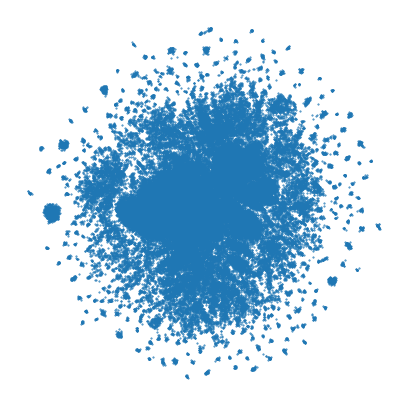

In [23]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(translated_embedding[:, 0], translated_embedding[:, 1], s=0.2);
ax.axis('off');

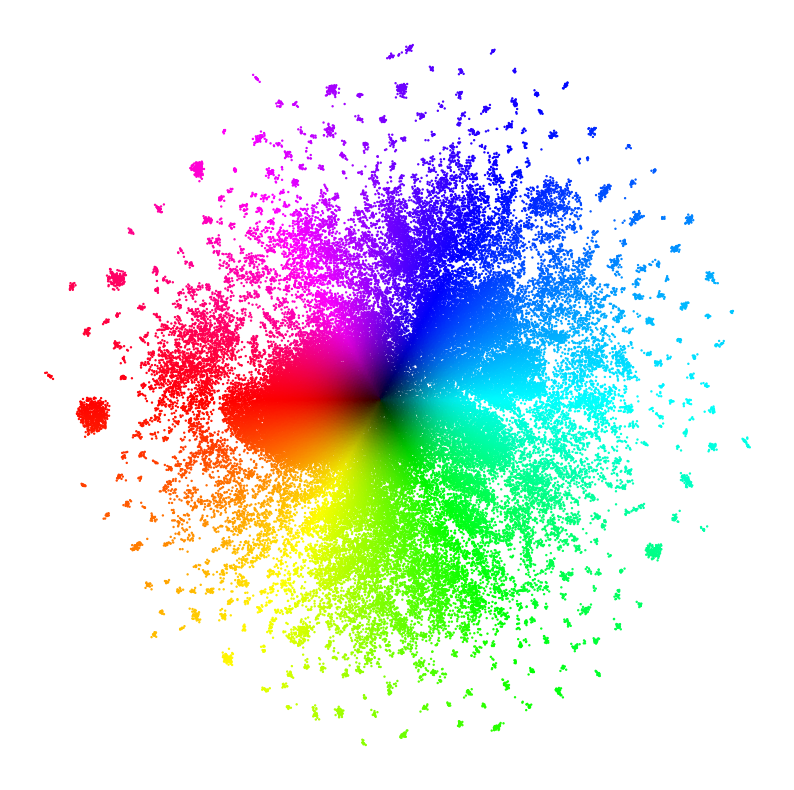

In [24]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(translated_embedding[:, 0], translated_embedding[:, 1], color=circ_colors, s=0.5);
ax.axis('off');
fig.savefig(os.path.join("..","Images","Word2Vec_2D_UMAP_Projection.png"), dpi=300)

In [56]:
# 将颜色信息保存至Airbnb_Listing
"""
Airbnb_Listing['Word2Vec_UMAP_Xcor'] = color_info[:, 0]  # 第一列
Airbnb_Listing['Word2Vec_UMAP_Ycor'] = color_info[:, 1]  # 第二列
Airbnb_Listing['Word2Vec_UMAP_colorR'] = color_info[:, 2]  # 第三列
Airbnb_Listing['Word2Vec_UMAP_colorG'] = color_info[:, 3]  # 第四列
Airbnb_Listing['Word2Vec_UMAP_colorB'] = color_info[:, 4]  # 第五列
"""

In [68]:
#保存颜色信息
#Airbnb_Listing.to_csv(os.path.join("..","Data","Airbnb_Ame2Vec_UMAP2color.csv"))

In [8]:
#读取颜色信息
Airbnb_Listing = pd.read_csv(os.path.join("..","Data","Airbnb_Ame2Vec_UMAP2color.csv"),low_memory=False)

In [9]:
London_boroughs = gpd.read_file(os.path.join("..","London_Boroughs.gpkg"), compression='gzip', low_memory=False)
London_wards = gpd.read_file(os.path.join("..","Data","London-wards-2018","London-wards-2018_ESRI","London_Ward.shp"),compression='gzip', low_memory=False)

In [10]:
# Transfer pandas dataframe (Airbnb_listing.csv) to geopandas geodataframe
# By using the coordinates ()

# Converting to GeoDataframe
gdf_listing = gpd.GeoDataFrame(Airbnb_Listing, geometry=gpd.points_from_xy(Airbnb_Listing.longitude, Airbnb_Listing.latitude))

# Set the CRS
gdf_listing.set_crs("EPSG:4326", inplace=True)  # (EPSG:4326)

print("Converting successful")

# Drop NAs of columns ['description','amenities']
gdf_listing = gdf_listing.dropna(subset=['description','amenities'])
print(f"Now gdf has {gdf_listing.shape[0]:,} rows and {gdf_listing.shape[1]:,} columns.")

Converting successful
Now gdf has 86,679 rows and 29 columns.


In [11]:
gdf_listing = gdf_listing.to_crs(epsg=3857)
London_boroughs = London_boroughs.to_crs(epsg=3857)
London_wards = London_wards.to_crs(epsg=3857)
print("gdf_listing CRS:", gdf_listing.crs)
print("London_boroughs CRS:", London_boroughs.crs)
print("London_wards CRS:", London_wards.crs)

gdf_listing CRS: EPSG:3857
London_boroughs CRS: EPSG:3857
London_wards CRS: EPSG:3857


In [50]:
# 调整RGB三色的值(可选)

#gdf_listing['Word2Vec_UMAP_colorR'] = gdf_listing['Word2Vec_UMAP_colorR']
#gdf_listing['Word2Vec_UMAP_colorG'] = gdf_listing['Word2Vec_UMAP_colorG']*(5/3)
#gdf_listing['Word2Vec_UMAP_colorB'] = gdf_listing['Word2Vec_UMAP_colorB']


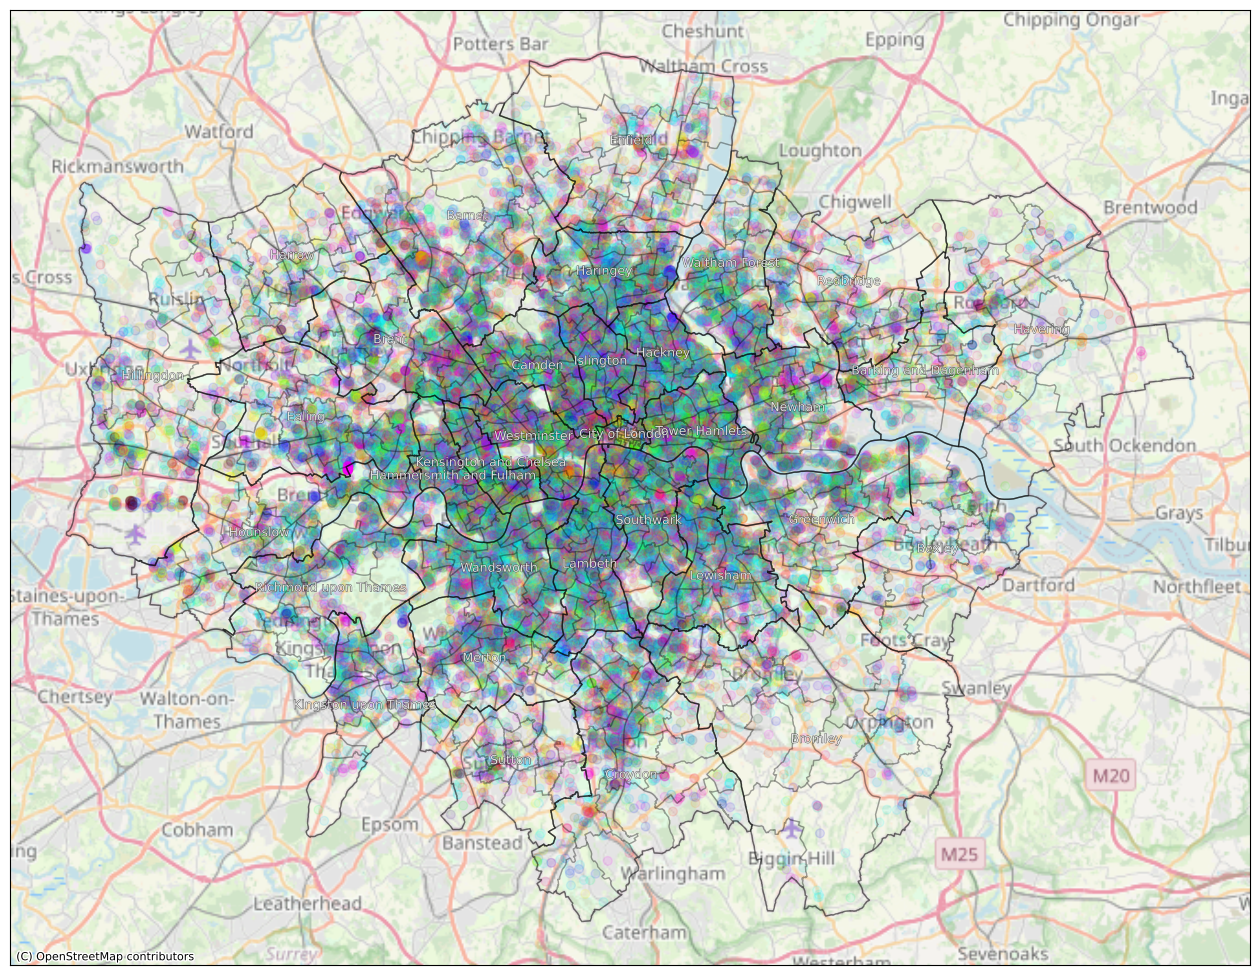

In [16]:
# 绘制地图
fig, ax = plt.subplots(figsize=(16, 16))

London_boroughs.boundary.plot(ax=ax, edgecolor='black', linewidth=1, alpha=0.4)
London_wards.boundary.plot(ax=ax, edgecolor='black', linewidth=1, alpha=0.2)

# 从 gdf_listing 提取坐标点和 RGB 颜色值
x = gdf_listing.geometry.x  # 经度
y = gdf_listing.geometry.y  # 纬度
colors = gdf_listing[['Word2Vec_UMAP_colorR', 'Word2Vec_UMAP_colorG', 'Word2Vec_UMAP_colorB']].values  # RGB 颜色值

# 增加colors的亮度（通过增加 50% 的亮度）
brightness_factor = 1.5
colors_brightened = np.clip(colors * brightness_factor, 0, 1)  # 确保值在 0 到 1 之间

# 绘制散点图
ax.scatter(x, y, color=colors_brightened, s=40, alpha=0.1)  # 假设 RGB 值在 0-255 范围内

# 添加区域名称的文字标签
for idx, row in London_boroughs.iterrows():
    centroid = row.geometry.centroid
    text = ax.text(centroid.x, centroid.y, row['name'], fontsize=9, color='white',ha='center', va='center', alpha=0.7,
                   path_effects=[PathEffects.withStroke(linewidth=0.5, foreground='black')])
 
#OSM彩色底图,透明图0.7
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha = 0.7)              

# 隐藏坐标轴
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.show()

# 保存为 PNG 文件，分辨率为 300 dpi
fig.savefig(os.path.join("..","Images","Word2Vec_OSM_geospace.png"), dpi=300)  

**两张图一左一右布置**

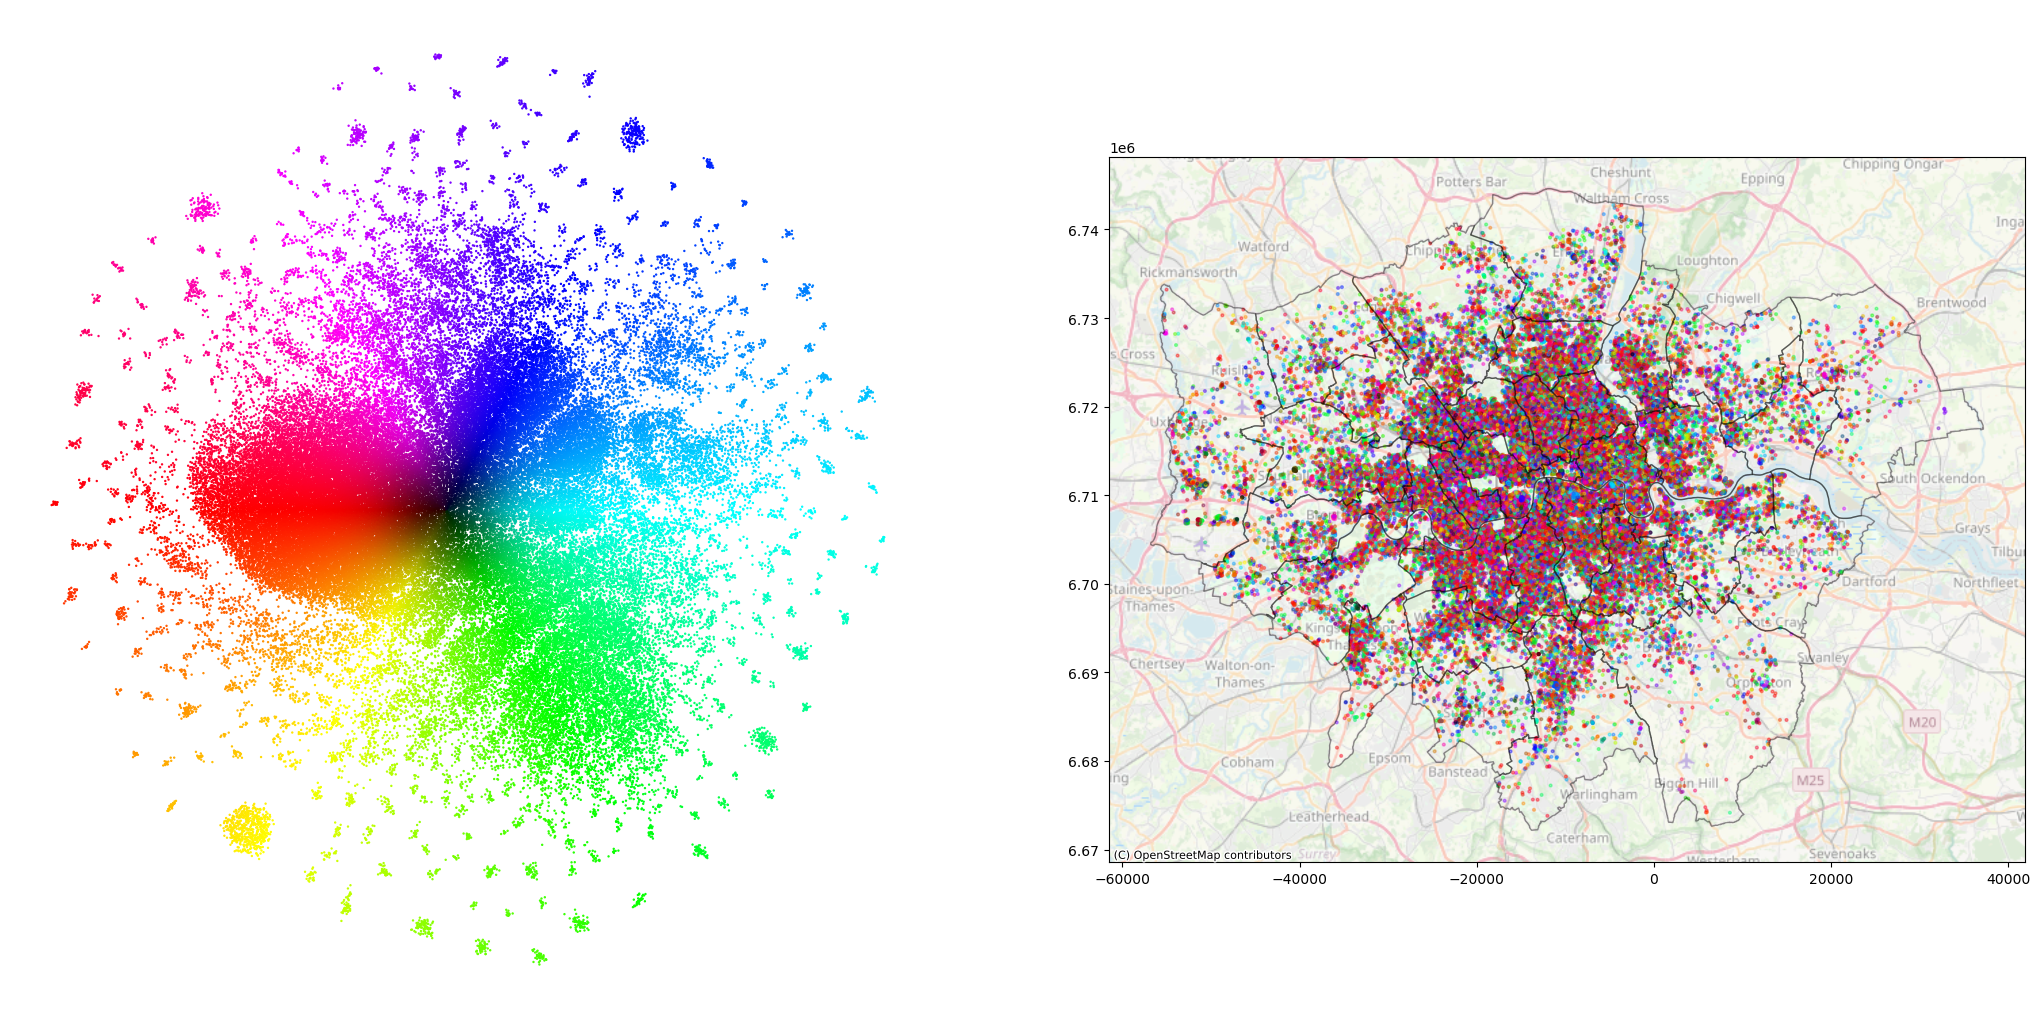

In [55]:
# 创建子图布局
fig, axs = plt.subplots(1, 2, figsize=(26, 13))

# 第一张图
axs[0].scatter(translated_embedding[:, 0], translated_embedding[:, 1], color=circ_colors, s=0.5)
axs[0].axis('off')

# 第二张图
London_boroughs.boundary.plot(ax=axs[1], edgecolor='black', linewidth=1, alpha=0.4)
London_wards.boundary.plot(ax=ax, edgecolor='black', linewidth=1, alpha=0.2)

x = gdf_listing.geometry.x
y = gdf_listing.geometry.y
colors = gdf_listing[['Word2Vec_UMAP_colorR', 'Word2Vec_UMAP_colorG', 'Word2Vec_UMAP_colorB']].values
axs[1].scatter(x, y, color=colors, s=4, alpha=0.4)
ctx.add_basemap(ax=axs[1], source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)

ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.show()

**方案二：第一张作为附图放在第二张图的左上角**

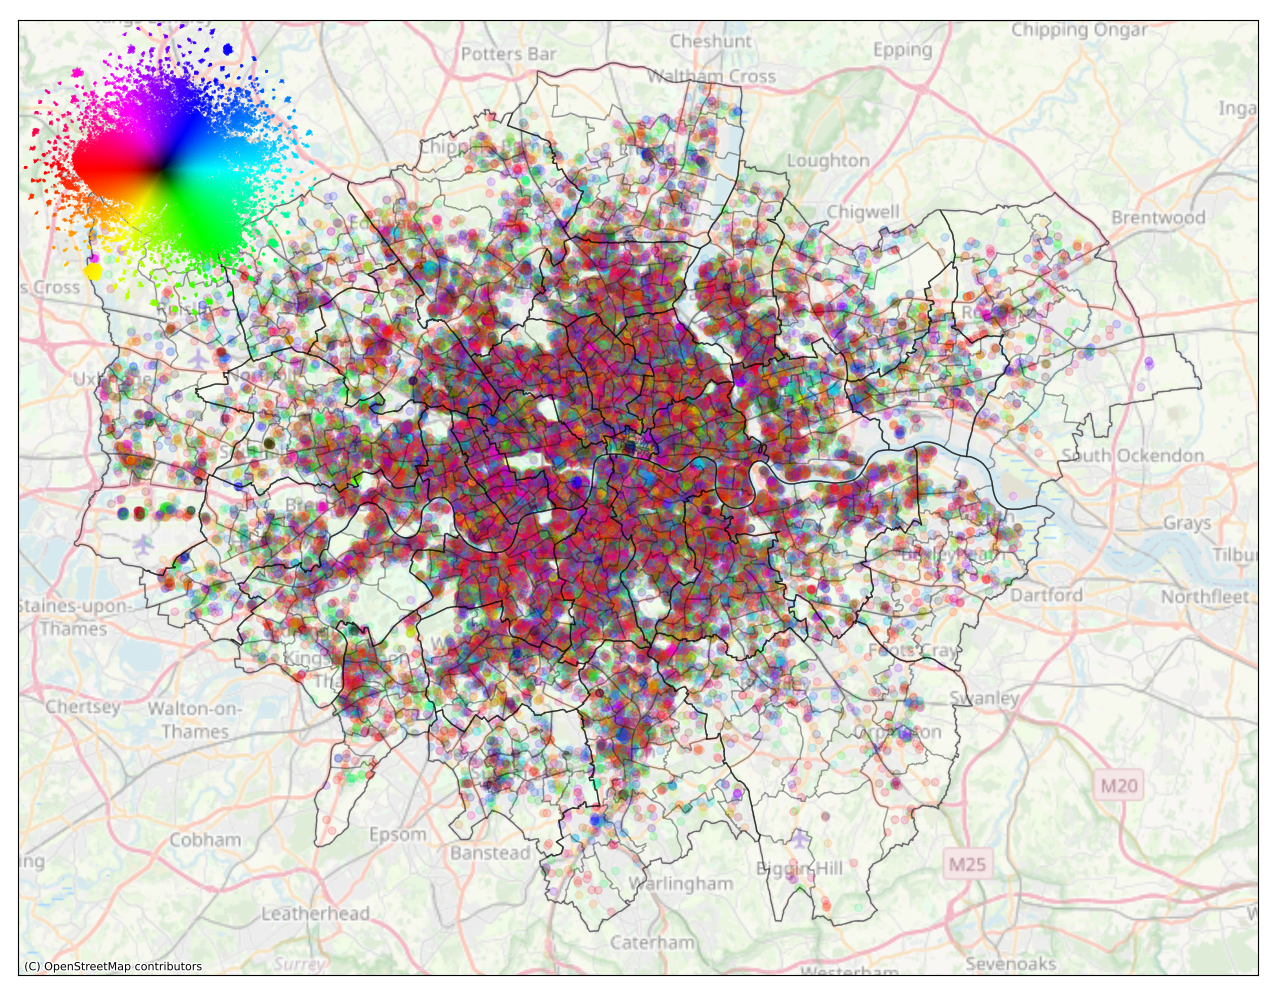

In [56]:
import matplotlib.pyplot as plt


# 绘制第二张图（主图）
fig, ax = plt.subplots(figsize=(16, 16))
#borough和wards的边界
London_boroughs.boundary.plot(ax=ax, edgecolor='black', linewidth=1, alpha=0.4)
London_wards.boundary.plot(ax=ax, edgecolor='black', linewidth=1, alpha=0.2)

x = gdf_listing.geometry.x
y = gdf_listing.geometry.y
colors = gdf_listing[['Word2Vec_UMAP_colorR', 'Word2Vec_UMAP_colorG', 'Word2Vec_UMAP_colorB']].values
ax.scatter(x, y, color=colors, s=30, alpha=0.15)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, alpha=0.5)

#隐藏坐标轴
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

# 第一张图作为附图
left, bottom, width, height = [0.12,0.6,0.2,0.2] # 这些参数控制附属图的位置和大小
ax_inset = fig.add_axes([left, bottom, width, height])
ax_inset.scatter(translated_embedding[:, 0], translated_embedding[:, 1], color=circ_colors, s=0.1)
ax_inset.axis('off')



plt.show()

